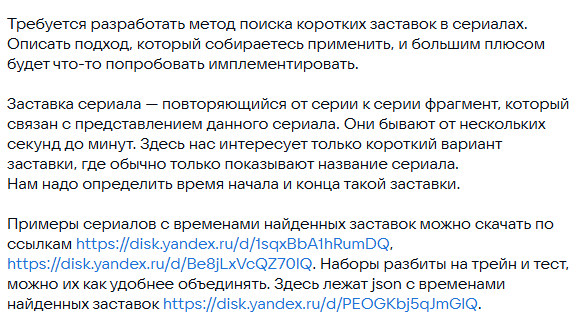

#Основная логика решения
Задача: Автоматическое обнаружение коротких заставок (интро) в сериалах по временным меткам начала и конца.

___Ключевые особенности:___

- Заставки повторяются в разных эпизодах одного сериала

- Используется сравнение визуального сходства между эпизодами

- Фокус на коротких интро (5-95 секунд)

#Пайплайн обработки
1. ___Подготовка данных___

  - Группировка эпизодов по сериалам

  - Парсинг временных меток из JSON

  - Проверка доступности видеофайлов

2. ___Извлечение признаков___

  - Использование CLIP-ViT модели для получения визуальных фич

  - Обработка с частотой 1 кадр/сек

  - Кэширование признаков для ускорения повторных запусков

3. ___Поиск заставки___

  - Построение матрицы косинусной схожести кадров

  - Применение динамического программирования для поиска длинных совпадений

  - Фильтрация по порогу сходства (0.92) и длительности (5-95 сек)

4. ___Оценка результатов___

  - Расчет IoU (Intersection over Union)

  - Сравнение с ground truth разметкой

  - Статистика по обнаруженным интро

In [ ]:
!pip install torch torchvision torchaudio
!pip install transformers accelerate Pillow opencv-python numpy scikit-learn tqdm

In [ ]:
import os
import json
import re
import argparse
import numpy as np
import cv2
import torch
from PIL import Image
from transformers import CLIPProcessor, CLIPModel
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm
from datetime import timedelta

In [ ]:
# --- ГЛАВНЫЕ НАСТРОЙКИ ---
#    В этой папке должны лежать подпапки 'train' и 'test'.
DATA_DIR = "."

#    Укажите путь к папке, где будут храниться кэшированные признаки видео.
#    Это сильно ускорит повторные запуски. Папка будет создана автоматически.
CACHE_DIR = "feature_cache"

#    Устройство для вычислений ('cuda' для GPU, 'cpu' для CPU).

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# --- Проверка и вывод настроек ---
print("--- Конфигурация запуска ---")
print(f"Директория с данными: {DATA_DIR}")
print(f"Директория для кэша: {CACHE_DIR}")
print(f"Устройство для вычислений: {DEVICE}")
print("---------------------------")

if not os.path.isdir(DATA_DIR):
    print(f"ВНИМАНИЕ: Директория с данными '{DATA_DIR}' не найдена!")
else:
    print("Директория с данными найдена.")

--- Конфигурация запуска ---
Директория с данными: .
Директория для кэша: feature_cache
Устройство для вычислений: cuda
---------------------------
Директория с данными найдена.


In [ ]:
# --- Вспомогательные функции ---
def time_str_to_seconds(time_str):
    """Конвертирует строку времени 'H:M:S' в секунды."""
    try:
        h, m, s = map(int, time_str.split(':'))
        return h * 3600 + m * 60 + s
    except (ValueError, TypeError):
        return 0

def seconds_to_time_str(seconds):
    """Конвертирует секунды в строку 'H:M:S'."""
    return str(timedelta(seconds=int(seconds)))

def calculate_iou(pred_start, pred_end, true_start, true_end):
    """Вычисляет Intersection over Union для двух временных интервалов."""
    intersection_start = max(pred_start, true_start)
    intersection_end = min(pred_end, true_end)
    intersection = max(0, intersection_end - intersection_start)
    union = (pred_end - pred_start) + (true_end - true_start) - intersection
    return intersection / union if union > 0 else 0

def load_and_group_data(dataset_path, video_extension=".mp4"):
    """Загружает разметку и группирует эпизоды по сериалам."""
    labels_path = os.path.join(dataset_path, f"labels.json")
    if not os.path.exists(labels_path):
        raise FileNotFoundError(f"Файл разметки не найден: {labels_path}")

    with open(labels_path, 'r', encoding='utf-8') as f:
        labels = json.load(f)

    series_map = {}
    print(f"Группировка видео из {labels_path}...")
    for video_id, data in tqdm(labels.items()):
        series_name_match = re.match(r'^([^.]+)', data['name'])
        if series_name_match:
            series_name = series_name_match.group(1).strip()
            if series_name not in series_map:
                series_map[series_name] = []

            video_path = os.path.join(dataset_path, video_id, f"{video_id}{video_extension}")
            if not os.path.exists(video_path):
                print(f"Предупреждение: Видеофайл не найден: {video_path}")
                continue

            series_map[series_name].append({
                'id': video_id,
                'path': video_path,
                'true_start': time_str_to_seconds(data.get('start')),
                'true_end': time_str_to_seconds(data.get('end'))
            })
    return series_map

In [ ]:
# --- Класс для извлечения признаков ---

class VideoFeatureExtractor:
    def __init__(self, model_name="openai/clip-vit-base-patch32", device="cpu", cache_dir="cache"):
        self.device = device
        self.model = CLIPModel.from_pretrained(model_name).to(self.device)
        self.processor = CLIPProcessor.from_pretrained(model_name)
        self.model.eval()
        self.cache_dir = cache_dir
        os.makedirs(self.cache_dir, exist_ok=True)
        print(f"Экстрактор признаков инициализирован на устройстве: {self.device}")

    def extract_features(self, video_path, sample_rate=1):
        video_id = os.path.splitext(os.path.basename(video_path))[0]
        cache_file = os.path.join(self.cache_dir, f"{video_id}_features.npz")

        if os.path.exists(cache_file):
            print(f"Загрузка признаков из кэша: {cache_file}")
            data = np.load(cache_file)
            return data['features'], data['timestamps']

        features, timestamps = [], []
        cap = cv2.VideoCapture(video_path)
        if not cap.isOpened():
            print(f"Ошибка: Не удалось открыть видео: {video_path}")
            return np.array([]), np.array([])

        video_fps = cap.get(cv2.CAP_PROP_FPS)
        frame_interval = int(video_fps / sample_rate) if sample_rate > 0 else 1
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

        with tqdm(total=total_frames, desc=f"Обработка {video_id}") as pbar:
            frame_count = 0
            with torch.no_grad():
                while cap.isOpened():
                    ret, frame = cap.read()
                    if not ret:
                        pbar.update(total_frames - pbar.n)
                        break
                    pbar.update(1)
                    if frame_count % frame_interval == 0:
                        timestamp = frame_count / video_fps
                        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                        image = Image.fromarray(frame_rgb)
                        inputs = self.processor(images=image, return_tensors="pt").to(self.device)
                        image_features = self.model.get_image_features(**inputs)
                        features.append(image_features.cpu().numpy().flatten())
                        timestamps.append(timestamp)
                    frame_count += 1
        cap.release()
        features_np, timestamps_np = np.array(features), np.array(timestamps)
        np.savez_compressed(cache_file, features=features_np, timestamps=timestamps_np)
        print(f"Признаки сохранены в кэш: {cache_file}")
        return features_np, timestamps_np

In [ ]:
# --- Алгоритм поиска совпадений ---

def find_intro_segment(features1, timestamps1, features2, timestamps2, similarity_threshold=0.92, min_len_sec=5, max_len_sec=95):
    if features1.shape[0] == 0 or features2.shape[0] == 0: return None
    print("Вычисление матрицы сходства...")
    similarity_matrix = cosine_similarity(features1, features2)
    print("Поиск наилучшего совпадения (DP)...")
    dp_matrix, max_len, best_end_pos = np.zeros_like(similarity_matrix, dtype=int), 0, (0, 0)

    for i in tqdm(range(1, similarity_matrix.shape[0])):
        for j in range(1, similarity_matrix.shape[1]):
            if similarity_matrix[i, j] > similarity_threshold:
                dp_matrix[i, j] = dp_matrix[i-1, j-1] + 1
                if dp_matrix[i, j] > max_len:
                    max_len, best_end_pos = dp_matrix[i, j], (i, j)

    match_len_sec = max_len / 1.0 # sample_rate=1
    if not (min_len_sec <= match_len_sec <= max_len_sec):
        print(f"Найдено совпадение длиной {match_len_sec:.1f} сек, но оно не проходит по фильтру длины ({min_len_sec}-{max_len_sec} сек).")
        return None

    end_idx1, end_idx2 = best_end_pos
    start_idx1, start_idx2 = end_idx1 - max_len + 1, end_idx2 - max_len + 1
    pred_start1, pred_end1 = timestamps1[start_idx1], timestamps1[end_idx1]
    pred_start2, pred_end2 = timestamps2[start_idx2], timestamps2[end_idx2]
    return pred_start1, pred_end1, pred_start2, pred_end2

print("Функции и классы успешно определены.")

Функции и классы успешно определены.


In [ ]:
# --- Основная логика ---
feature_extractor = VideoFeatureExtractor(device=DEVICE, cache_dir=CACHE_DIR)
# Извлечение признаков
for dataset_name in ["data_train_short", "data_test_short"]:
    dataset_path = os.path.join(DATA_DIR, dataset_name)
    if not os.path.isdir(dataset_path):
        print(f"Директория {dataset_path} не найдена, пропускаем.")
        continue

    print(f"\n{'='*40}\n ОБРАБОТКА НАБОРА: {dataset_name.upper()} \n{'='*40}")

    try:
        series_map = load_and_group_data(dataset_path)
    except FileNotFoundError as e:
        print(e)
        continue

    total_series, found_intros, all_ious = 0, 0, []

    for series_name, episodes in series_map.items():
        if len(episodes) < 2:
            continue

        total_series += 1
        print(f"\n--- Обработка сериала: {series_name} ---")

        ep1_data, ep2_data = episodes[0], episodes[1]

        features1, timestamps1 = feature_extractor.extract_features(ep1_data['path'])
        features2, timestamps2 = feature_extractor.extract_features(ep2_data['path'])

        if features1.size == 0 or features2.size == 0:
            print("Не удалось извлечь признаки для одного из видео, пропуск.")
            continue
        # Поиск заставки
        match = find_intro_segment(features1, timestamps1, features2, timestamps2)

        if match:
            found_intros += 1
            pred_s1, pred_e1, pred_s2, pred_e2 = match

            iou1 = calculate_iou(pred_s1, pred_e1, ep1_data['true_start'], ep1_data['true_end'])
            iou2 = calculate_iou(pred_s2, pred_e2, ep2_data['true_start'], ep2_data['true_end'])
            avg_iou = (iou1 + iou2) / 2
            all_ious.append(avg_iou)

            print("\n НАЙДЕНО СОВПАДЕНИЕ!")
            print(f"  Серия 1 ({ep1_data['id']}):")
            print(f"    Предсказано: {seconds_to_time_str(pred_s1)} - {seconds_to_time_str(pred_e1)}")
            print(f"    Эталон:     {seconds_to_time_str(ep1_data['true_start'])} - {seconds_to_time_str(ep1_data['true_end'])}")
            print(f"    IoU: {iou1:.4f}")
            print(f"  Серия 2 ({ep2_data['id']}):")
            print(f"    Предсказано: {seconds_to_time_str(pred_s2)} - {seconds_to_time_str(pred_e2)}")
            print(f"    Эталон:     {seconds_to_time_str(ep2_data['true_start'])} - {seconds_to_time_str(ep2_data['true_end'])}")
            print(f"    IoU: {iou2:.4f}")
            print(f"  Средний IoU для пары: {avg_iou:.4f}")
        else:
            print("\n Совпадение не найдено или отфильтровано по длине.")
    # --- Итоги по набору данных ---
    print(f"\n--- ИТОГИ ПО НАБОРУ {dataset_name.upper()} ---")
    if total_series > 0:
        print(f"Всего сериалов для обработки (>= 2 серий): {total_series}")
        print(f"Найдено заставок: {found_intros} ({found_intros/total_series:.2%})")
        if all_ious:
            mean_iou = np.mean(all_ious)
            print(f"Средний IoU по найденным заставкам: {mean_iou:.4f}")
    else:
        print("В наборе не найдено сериалов для обработки.")

print("\n Анализ полностью завершен!")

Экстрактор признаков инициализирован на устройстве: cuda

 ОБРАБОТКА НАБОРА: DATA_TRAIN_SHORT 
Группировка видео из .\data_train_short\labels.json...


100%|████████████████████████████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 7999.82it/s]



--- Обработка сериала: Баскетс ---
Загрузка признаков из кэша: feature_cache\-220020068_456255414_features.npz
Загрузка признаков из кэша: feature_cache\-220020068_456255402_features.npz
Вычисление матрицы сходства...
Поиск наилучшего совпадения (DP)...


100%|████████████████████████████████████████████████████████████████████████████| 1610/1610 [00:00<00:00, 6467.10it/s]



 НАЙДЕНО СОВПАДЕНИЕ!
  Серия 1 (-220020068_456255414):
    Предсказано: 0:00:00 - 0:00:04
    Эталон:     0:01:42 - 0:01:47
    IoU: 0.0000
  Серия 2 (-220020068_456255402):
    Предсказано: 0:00:00 - 0:00:04
    Эталон:     0:00:17 - 0:00:22
    IoU: 0.0000
  Средний IoU для пары: 0.0000

--- Обработка сериала: Бывaeт и xyжe ---
Загрузка признаков из кэша: feature_cache\-220020068_456249693_features.npz
Загрузка признаков из кэша: feature_cache\-220020068_456249732_features.npz
Вычисление матрицы сходства...
Поиск наилучшего совпадения (DP)...


100%|████████████████████████████████████████████████████████████████████████████| 1357/1357 [00:00<00:00, 8224.33it/s]



 НАЙДЕНО СОВПАДЕНИЕ!
  Серия 1 (-220020068_456249693):
    Предсказано: 0:21:35 - 0:21:40
    Эталон:     0:00:06 - 0:00:10
    IoU: 0.0000
  Серия 2 (-220020068_456249732):
    Предсказано: 0:20:40 - 0:20:46
    Эталон:     0:00:06 - 0:00:10
    IoU: 0.0000
  Средний IoU для пары: 0.0000

--- Обработка сериала: Анатомия скандала ---
Загрузка признаков из кэша: feature_cache\-220020068_456255339_features.npz
Загрузка признаков из кэша: feature_cache\-220020068_456255340_features.npz
Вычисление матрицы сходства...
Поиск наилучшего совпадения (DP)...


100%|████████████████████████████████████████████████████████████████████████████| 2185/2185 [00:00<00:00, 4770.75it/s]



 НАЙДЕНО СОВПАДЕНИЕ!
  Серия 1 (-220020068_456255339):
    Предсказано: 0:00:09 - 0:00:19
    Эталон:     0:00:10 - 0:00:20
    IoU: 0.9999
  Серия 2 (-220020068_456255340):
    Предсказано: 0:00:11 - 0:00:21
    Эталон:     0:00:11 - 0:00:21
    IoU: 0.8182
  Средний IoU для пары: 0.9091

--- Обработка сериала: Блеск ---
Загрузка признаков из кэша: feature_cache\-220020068_456241755_features.npz
Загрузка признаков из кэша: feature_cache\-220020068_456241756_features.npz
Вычисление матрицы сходства...
Поиск наилучшего совпадения (DP)...


100%|████████████████████████████████████████████████████████████████████████████| 1968/1968 [00:00<00:00, 6267.51it/s]



 НАЙДЕНО СОВПАДЕНИЕ!
  Серия 1 (-220020068_456241755):
    Предсказано: 0:30:03 - 0:30:19
    Эталон:     0:03:08 - 0:03:12
    IoU: 0.0000
  Серия 2 (-220020068_456241756):
    Предсказано: 0:25:12 - 0:25:29
    Эталон:     0:01:06 - 0:01:10
    IoU: 0.0000
  Средний IoU для пары: 0.0000

--- Обработка сериала: Амepикaнcкий вaндaл ---
Загрузка признаков из кэша: feature_cache\-220020068_456241671_features.npz
Загрузка признаков из кэша: feature_cache\-220020068_456241672_features.npz
Вычисление матрицы сходства...
Поиск наилучшего совпадения (DP)...


100%|████████████████████████████████████████████████████████████████████████████| 2313/2313 [00:00<00:00, 4828.82it/s]



 НАЙДЕНО СОВПАДЕНИЕ!
  Серия 1 (-220020068_456241671):
    Предсказано: 0:00:00 - 0:00:54
    Эталон:     0:03:47 - 0:03:10
    IoU: 0.0000
  Серия 2 (-220020068_456241672):
    Предсказано: 0:00:00 - 0:00:54
    Эталон:     0:03:51 - 0:03:15
    IoU: 0.0000
  Средний IoU для пары: 0.0000

--- Обработка сериала: Бриджертоны ---
Загрузка признаков из кэша: feature_cache\-220020068_456256016_features.npz
Загрузка признаков из кэша: feature_cache\-220020068_456256013_features.npz
Вычисление матрицы сходства...
Поиск наилучшего совпадения (DP)...


100%|████████████████████████████████████████████████████████████████████████████| 2333/2333 [00:00<00:00, 4304.43it/s]



 НАЙДЕНО СОВПАДЕНИЕ!
  Серия 1 (-220020068_456256016):
    Предсказано: 0:00:00 - 0:00:24
    Эталон:     0:04:32 - 0:04:38
    IoU: 0.0000
  Серия 2 (-220020068_456256013):
    Предсказано: 0:00:00 - 0:00:24
    Эталон:     0:03:20 - 0:03:26
    IoU: 0.0000
  Средний IoU для пары: 0.0000

--- Обработка сериала: Бойцовская ночь: Афера на миллион ---
Загрузка признаков из кэша: feature_cache\-220020068_456256475_features.npz
Загрузка признаков из кэша: feature_cache\-220020068_456256571_features.npz
Вычисление матрицы сходства...
Поиск наилучшего совпадения (DP)...


100%|████████████████████████████████████████████████████████████████████████████| 2820/2820 [00:00<00:00, 3709.17it/s]



 НАЙДЕНО СОВПАДЕНИЕ!
  Серия 1 (-220020068_456256475):
    Предсказано: 0:45:57 - 0:46:13
    Эталон:     0:10:42 - 0:10:25
    IoU: 0.0000
  Серия 2 (-220020068_456256571):
    Предсказано: 0:43:54 - 0:44:10
    Эталон:     0:04:43 - 0:04:26
    IoU: 0.0000
  Средний IoU для пары: 0.0000

--- Обработка сериала: Белые линии ---
Загрузка признаков из кэша: feature_cache\-220020068_456257139_features.npz
Загрузка признаков из кэша: feature_cache\-220020068_456257141_features.npz
Вычисление матрицы сходства...
Поиск наилучшего совпадения (DP)...


100%|████████████████████████████████████████████████████████████████████████████| 2654/2654 [00:00<00:00, 3650.62it/s]



 НАЙДЕНО СОВПАДЕНИЕ!
  Серия 1 (-220020068_456257139):
    Предсказано: 0:00:00 - 0:00:14
    Эталон:     0:04:05 - 0:04:13
    IoU: 0.0000
  Серия 2 (-220020068_456257141):
    Предсказано: 0:00:00 - 0:00:14
    Эталон:     0:04:20 - 0:04:27
    IoU: 0.0000
  Средний IoU для пары: 0.0000

--- Обработка сериала: Берлин ---
Загрузка признаков из кэша: feature_cache\-220020068_456254621_features.npz
Загрузка признаков из кэша: feature_cache\-220020068_456254614_features.npz
Вычисление матрицы сходства...
Поиск наилучшего совпадения (DP)...


100%|████████████████████████████████████████████████████████████████████████████| 2333/2333 [00:00<00:00, 4444.32it/s]



 НАЙДЕНО СОВПАДЕНИЕ!
  Серия 1 (-220020068_456254621):
    Предсказано: 0:07:10 - 0:07:22
    Эталон:     0:07:39 - 0:07:22
    IoU: 0.0000
  Серия 2 (-220020068_456254614):
    Предсказано: 0:08:09 - 0:08:22
    Эталон:     0:08:39 - 0:08:22
    IoU: 0.0000
  Средний IoU для пары: 0.0000

--- Обработка сериала: Архив 81 ---
Загрузка признаков из кэша: feature_cache\-220020068_456255344_features.npz
Загрузка признаков из кэша: feature_cache\-220020068_456255346_features.npz
Вычисление матрицы сходства...
Поиск наилучшего совпадения (DP)...


100%|████████████████████████████████████████████████████████████████████████████| 2335/2335 [00:00<00:00, 4422.74it/s]



 НАЙДЕНО СОВПАДЕНИЕ!
  Серия 1 (-220020068_456255344):
    Предсказано: 0:00:00 - 0:00:10
    Эталон:     0:01:53 - 0:01:27
    IoU: 0.0000
  Серия 2 (-220020068_456255346):
    Предсказано: 0:00:00 - 0:00:10
    Эталон:     0:01:51 - 0:01:26
    IoU: 0.0000
  Средний IoU для пары: 0.0000

--- Обработка сериала: Букмекер ---
Загрузка признаков из кэша: feature_cache\-220020068_456254282_features.npz
Загрузка признаков из кэша: feature_cache\-220020068_456254537_features.npz
Вычисление матрицы сходства...
Поиск наилучшего совпадения (DP)...


100%|████████████████████████████████████████████████████████████████████████████| 1349/1349 [00:00<00:00, 6813.17it/s]



 НАЙДЕНО СОВПАДЕНИЕ!
  Серия 1 (-220020068_456254282):
    Предсказано: 0:22:03 - 0:22:28
    Эталон:     0:03:09 - 0:03:19
    IoU: 0.0000
  Серия 2 (-220020068_456254537):
    Предсказано: 0:24:11 - 0:24:36
    Эталон:     0:02:09 - 0:02:20
    IoU: 0.0000
  Средний IoU для пары: 0.0000

--- Обработка сериала: Бодкин ---
Загрузка признаков из кэша: feature_cache\-220020068_456255766_features.npz
Загрузка признаков из кэша: feature_cache\-220020068_456255767_features.npz
Вычисление матрицы сходства...
Поиск наилучшего совпадения (DP)...


100%|████████████████████████████████████████████████████████████████████████████| 2259/2259 [00:00<00:00, 4610.61it/s]



 НАЙДЕНО СОВПАДЕНИЕ!
  Серия 1 (-220020068_456255766):
    Предсказано: 0:00:00 - 0:00:18
    Эталон:     0:03:01 - 0:03:11
    IoU: 0.0000
  Серия 2 (-220020068_456255767):
    Предсказано: 0:00:00 - 0:00:18
    Эталон:     0:01:58 - 0:01:08
    IoU: 0.0000
  Средний IoU для пары: 0.0000

--- Обработка сериала: Американские Истории Ужасов ---
Загрузка признаков из кэша: feature_cache\-220020068_456253855_features.npz
Загрузка признаков из кэша: feature_cache\-220020068_456253876_features.npz
Вычисление матрицы сходства...
Поиск наилучшего совпадения (DP)...


100%|████████████████████████████████████████████████████████████████████████████| 2332/2332 [00:00<00:00, 4486.46it/s]



 НАЙДЕНО СОВПАДЕНИЕ!
  Серия 1 (-220020068_456253855):
    Предсказано: 0:00:00 - 0:00:05
    Эталон:     0:08:31 - 0:08:12
    IoU: 0.0000
  Серия 2 (-220020068_456253876):
    Предсказано: 0:00:00 - 0:00:05
    Эталон:     0:12:48 - 0:12:29
    IoU: 0.0000
  Средний IoU для пары: 0.0000

--- ИТОГИ ПО НАБОРУ DATA_TRAIN_SHORT ---
Всего сериалов для обработки (>= 2 серий): 13
Найдено заставок: 13 (100.00%)
Средний IoU по найденным заставкам: 0.0699

 ОБРАБОТКА НАБОРА: DATA_TEST_SHORT 
Группировка видео из .\data_test_short\labels.json...


100%|███████████████████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 44992.53it/s]



--- Обработка сериала: 24 часа ---
Загрузка признаков из кэша: feature_cache\-220020068_456249220_features.npz
Загрузка признаков из кэша: feature_cache\-220020068_456249373_features.npz
Вычисление матрицы сходства...
Поиск наилучшего совпадения (DP)...


100%|███████████████████████████████████████████████████████████████████████████| 1044/1044 [00:00<00:00, 10038.75it/s]



 НАЙДЕНО СОВПАДЕНИЕ!
  Серия 1 (-220020068_456249220):
    Предсказано: 0:00:00 - 0:00:16
    Эталон:     0:00:05 - 0:00:16
    IoU: 0.7167
  Серия 2 (-220020068_456249373):
    Предсказано: 0:00:00 - 0:00:16
    Эталон:     0:00:05 - 0:00:16
    IoU: 0.7167
  Средний IoU для пары: 0.7167

--- Обработка сериала: Анатомия скандала ---
Загрузка признаков из кэша: feature_cache\-220020068_456255339_features.npz
Загрузка признаков из кэша: feature_cache\-220020068_456255338_features.npz
Вычисление матрицы сходства...
Поиск наилучшего совпадения (DP)...


100%|████████████████████████████████████████████████████████████████████████████| 2185/2185 [00:00<00:00, 4871.28it/s]



 НАЙДЕНО СОВПАДЕНИЕ!
  Серия 1 (-220020068_456255339):
    Предсказано: 0:00:00 - 0:00:09
    Эталон:     0:00:10 - 0:00:20
    IoU: 0.0000
  Серия 2 (-220020068_456255338):
    Предсказано: 0:00:00 - 0:00:09
    Эталон:     0:01:36 - 0:01:42
    IoU: 0.0000
  Средний IoU для пары: 0.0000

--- Обработка сериала: Бывaeт и xyжe ---
Загрузка признаков из кэша: feature_cache\-220020068_456249716_features.npz
Загрузка признаков из кэша: feature_cache\-220020068_456249720_features.npz
Вычисление матрицы сходства...
Поиск наилучшего совпадения (DP)...


100%|████████████████████████████████████████████████████████████████████████████| 1249/1249 [00:00<00:00, 8163.42it/s]



 НАЙДЕНО СОВПАДЕНИЕ!
  Серия 1 (-220020068_456249716):
    Предсказано: 0:00:00 - 0:00:07
    Эталон:     0:00:06 - 0:00:09
    IoU: 0.2500
  Серия 2 (-220020068_456249720):
    Предсказано: 0:00:00 - 0:00:07
    Эталон:     0:00:06 - 0:00:09
    IoU: 0.2500
  Средний IoU для пары: 0.2500

--- Обработка сериала: Баскетс ---
Загрузка признаков из кэша: feature_cache\-220020068_456255389_features.npz
Загрузка признаков из кэша: feature_cache\-220020068_456255393_features.npz
Вычисление матрицы сходства...
Поиск наилучшего совпадения (DP)...


100%|████████████████████████████████████████████████████████████████████████████| 1381/1381 [00:00<00:00, 7192.74it/s]


 НАЙДЕНО СОВПАДЕНИЕ!
  Серия 1 (-220020068_456255389):
    Предсказано: 0:22:48 - 0:22:54
    Эталон:     0:00:00 - 0:00:08
    IoU: 0.0000
  Серия 2 (-220020068_456255393):
    Предсказано: 0:22:11 - 0:22:17
    Эталон:     0:01:50 - 0:01:55
    IoU: 0.0000
  Средний IoU для пары: 0.0000

--- ИТОГИ ПО НАБОРУ DATA_TEST_SHORT ---
Всего сериалов для обработки (>= 2 серий): 4
Найдено заставок: 4 (100.00%)
Средний IoU по найденным заставкам: 0.2417

 Анализ полностью завершен!


#Итог
Текуший вариант реализации является лишь baseline решением и необходимо для демонстрации идеи. Следующими задачами для улучшения текущего решения будут:
1. Значительное улучшение алгоритма нахождения схожести признаков.
- Искать сходство больше чем по двум эпизодам сериала
- Улучшить сам алгоритм поиска
2. Фильтрация найденных похожих фрагментов. (т.к. похожими могут быть титры, интро компании производителя и т.д.)
- Использовать поверх классификатор
- Определить временные рамки для каждого типа схожих видеофрагментов
3. Использовать гибридные подходы.
- Экстрактить аудио признаки и использовать поиск по их схожести
